In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: False


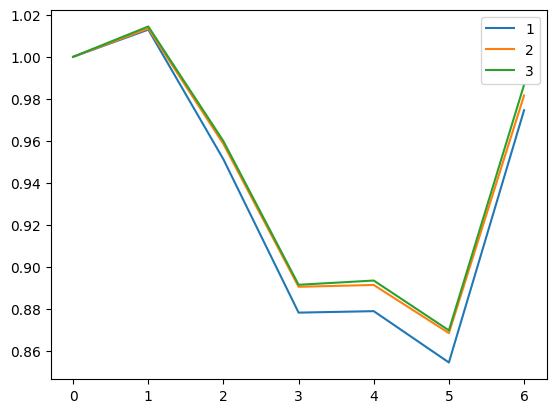

In [3]:
N_NEEDED = 7

perf1 = np.array([ 99957,101250, 95082, 87795, 87865, 85425, 97416])
perf2 = np.array([ 98466, 99793, 94381, 87695, 87781, 85526, 96654])
perf3 = np.array([ 98957,100385, 94984, 88227, 88427, 86081, 97637])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [ 54242, 62268, 63273]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 3  # [1, 2, 3]
MUTATE_SCALE = 0.405  # x0.9 or x1.1 decrease if same; incr if new

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,82.220001,1,0.384646,0.615354,0.791252,0.024258,0.653910
1,AAPL,198.850006,0,0.176729,0.823271,0.386481,0.105395,0.814823
2,ABNB,121.320000,0,0.429637,0.570363,0.735971,0.302181,0.163390
3,ACN,299.940002,0,0.143543,0.856457,0.224652,0.056880,0.651961
4,ADBE,364.640015,0,0.111555,0.888445,0.183698,0.045588,0.636632


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating...')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,1068.86,1068.86,1151.08
AAPL,795.40,596.55,795.40
ABBV,539.52,539.52,719.36
ABT,508.16,0.00,0.00
ACN,899.82,899.82,899.82


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,82.22,0.004943,0.005094,0.004854
1,AAPL,198.85,0.006819,0.006546,0.006770
2,ABNB,121.32,0.002929,0.003462,0.003473
3,ACN,299.94,0.006824,0.006563,0.006783
4,ADBE,364.64,0.006847,0.006571,0.006791


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[194832.08000000002, 193307.65999999997, 195275.28]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,82.22,0.004943,0.005094,0.004854,963.06,984.71,947.93
AAPL,198.85,0.006819,0.006546,0.006770,1328.48,1265.34,1322.03
ABNB,121.32,0.002929,0.003462,0.003473,570.74,669.26,678.11
ACN,299.94,0.006824,0.006563,0.006783,1329.57,1268.64,1324.49
ADBE,364.64,0.006847,0.006571,0.006791,1334.06,1270.15,1326.20


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,82.22,0.004943,0.005094,0.004854,963.06,984.71,947.93,1068.86,1068.86,1151.08
AAPL,198.85,0.006819,0.006546,0.006770,1328.48,1265.34,1322.03,795.40,596.55,795.40
ABNB,121.32,0.002929,0.003462,0.003473,570.74,669.26,678.11,0.00,0.00,0.00
ACN,299.94,0.006824,0.006563,0.006783,1329.57,1268.64,1324.49,899.82,899.82,899.82
ADBE,364.64,0.006847,0.006571,0.006791,1334.06,1270.15,1326.20,1093.92,364.64,1093.92


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,82.22,0.004943,0.005094,0.004854,963.06,984.71,947.93,1068.86,1068.86,1151.08,-105.80,-84.15,-203.15
AAPL,198.85,0.006819,0.006546,0.006770,1328.48,1265.34,1322.03,795.40,596.55,795.40,533.08,668.79,526.63
ABNB,121.32,0.002929,0.003462,0.003473,570.74,669.26,678.11,0.00,0.00,0.00,570.74,669.26,678.11
ACN,299.94,0.006824,0.006563,0.006783,1329.57,1268.64,1324.49,899.82,899.82,899.82,429.75,368.82,424.67
ADBE,364.64,0.006847,0.006571,0.006791,1334.06,1270.15,1326.20,1093.92,364.64,1093.92,240.14,905.51,232.28


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,82.22,0.004943,0.005094,0.004854,963.06,984.71,947.93,1068.86,1068.86,1151.08,-105.80,-84.15,-203.15,-1,-1,-2
AAPL,198.85,0.006819,0.006546,0.006770,1328.48,1265.34,1322.03,795.40,596.55,795.40,533.08,668.79,526.63,3,3,3
ABNB,121.32,0.002929,0.003462,0.003473,570.74,669.26,678.11,0.00,0.00,0.00,570.74,669.26,678.11,5,6,6
ACN,299.94,0.006824,0.006563,0.006783,1329.57,1268.64,1324.49,899.82,899.82,899.82,429.75,368.82,424.67,1,1,1
ADBE,364.64,0.006847,0.006571,0.006791,1334.06,1270.15,1326.20,1093.92,364.64,1093.92,240.14,905.51,232.28,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,7.79,0.003991,0.005423,0.005515,777.60,1048.39,1076.86,0.00,0.00,0.00,777.60,1048.39,1076.86,100,135,138
WING,246.22,0.005742,0.005356,0.005426,1118.67,1035.36,1059.50,984.88,984.88,984.88,133.79,50.48,74.62,1,0,0
WIT,2.89,0.003776,0.004912,0.004986,735.64,949.53,973.64,0.00,0.00,0.00,735.64,949.53,973.64,255,329,337


In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
TPX,54.47,1358.42,25
UVV,53.09,1315.64,25
TTC,68.94,1306.58,19
ELF,55.74,1300.59,23
HON,199.10,1299.60,7


In [22]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
GE,187.27,-219.91,-1
AXP,262.36,-287.14,-1
MCHP,44.90,-298.73,-7
SPY,548.62,-318.07,-1
COF,174.91,-526.71,-3


In [23]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
TPX,54.47,1275.85,23
RDFN,8.83,1269.77,144
UVV,53.09,1263.55,24
TTC,68.94,1262.68,18
MIY,11.20,1259.77,112


In [24]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
CMG,50.93,-69.44,-1
AAON,82.22,-84.15,-1
MCHP,44.90,-98.80,-2
GE,187.27,-109.98,-1
AXP,262.36,-222.75,-1


In [25]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
TPX,54.47,1330.83,24
KR,65.83,1319.05,20
RDFN,8.83,1312.19,149
UVV,53.09,1308.65,25
MIY,11.20,1304.97,117


In [26]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
ETN,283.59,-259.15,-1
MCHP,44.90,-301.75,-7
AXP,262.36,-381.73,-1
ASML,687.26,-388.41,-1
SPY,548.62,-436.20,-1


In [27]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
